Replicate [Dynamic Return Dependencies Across Industries: A Machine Learning Approach](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3120110&download=yes) by David Rapach, Jack Strauss, Jun Tu and Guofu Zhou.

1) Use Keras NN classification instead of linear regression

2) Add additional variables, 3 and 12-month MA, interest rate change, yield curve, Mkt-RF, seasonal dummy variables. With cross-validation and regularization we hope to do that without overfitting and possibly produce a better result.


 

In [1]:
import os
import sys
import warnings
import numpy as np
np.random.seed(1764)
import pandas as pd

import time 
import datetime
import copy
import random
random.seed(1764)
from itertools import product

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy numpy warnings

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, mean_squared_error, explained_variance_score, r2_score
from sklearn.linear_model import LinearRegression, Lasso, lasso_path, lars_path, LassoLarsIC
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.stats import chisquare

import tensorflow as tf
tf.set_random_seed(1764)
print(tf.__version__)
# confirm GPU is in use
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Input
from keras.models import Model

from keras.layers.recurrent import LSTM, GRU
from keras.regularizers import l1
from keras.models import Sequential
from keras.models import load_model
from keras import backend as K
    
import ffn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import plotly as py
# print (py.__version__) # requires version >= 1.9.0
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff

init_notebook_mode(connected=True)



1.8.0
[[22. 28.]
 [49. 64.]]


Using TensorFlow backend.


In [2]:
print("Loading data...")
data = pd.read_csv("30_Industry_Portfolios.csv")
data = data.set_index('yyyymm')
industries = list(data.columns)
# map industry names to col nums
ind_reverse_dict = dict([(industries[i], i) for i in range(len(industries))])

rfdata = pd.read_csv("F-F_Research_Data_Factors.csv")
rfdata = rfdata.set_index('yyyymm')
data['rf'] = rfdata['RF']

# subtract risk-free rate
# create a response variable led by 1 period to predict
for ind in industries:
    data[ind] = data[ind] - data['rf']

#for ind in industries:
#    data[ind+".3m"] = pd.rolling_mean(data[ind],3)
    
#for ind in industries:
#    data[ind+".6m"] = pd.rolling_mean(data[ind],6)

#for ind in industries:
#    data[ind+".12m"] = pd.rolling_mean(data[ind],12)
    
for ind in industries:
    data[ind+".lead"] = data[ind].shift(-1)

data = data.loc[data.index[data.index > 195911]]
data = data.drop(columns=['rf'])    
data = data.dropna(axis=0, how='any')

nresponses = len(industries)
npredictors = data.shape[1]-nresponses

predictors = list(data.columns[:npredictors])
predictor_reverse_dict = dict([(predictors[i], i) for i in range(len(predictors))])

responses = list(data.columns[-nresponses:])
response_reverse_dict = dict([(responses[i], i) for i in range(len(responses))])

print(data.shape)

data[['Food', 'Food.lead']]


Loading data...
(697, 60)


,Food,Food.lead
yyyymm,,
195912,2.01,-4.49
196001,-4.49,3.35
196002,3.35,-1.67
196003,-1.67,1.17
196004,1.17,8.20
196005,8.20,5.39
196006,5.39,-2.11
196007,-2.11,4.57
196008,4.57,-3.88


In [3]:
# exclude 2017 and later to tie to paper
data = data.loc[data.index[data.index < 201701]]
data = data.loc[data.index[data.index > 195911]]
data


,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm.lead,Servs.lead,BusEq.lead,Paper.lead,Trans.lead,Whlsl.lead,Rtail.lead,Meals.lead,Fin.lead,Other.lead
yyyymm,,,,,,,,,,,,,,,,,,,,,
195912,2.01,0.35,-3.02,1.64,7.29,0.67,1.87,-1.97,3.08,0.74,...,0.62,-6.18,-7.93,-9.41,-4.31,-5.33,-6.09,-10.08,-4.68,-3.98
196001,-4.49,-5.71,-2.05,1.21,-5.47,-7.84,-8.53,-6.68,-10.03,-4.77,...,8.07,9.13,5.09,3.00,-0.94,1.42,4.00,1.81,-0.98,6.32
196002,3.35,-2.14,2.27,4.23,2.39,9.31,1.44,-0.02,-0.74,0.32,...,-0.21,-0.31,3.34,-2.43,-4.99,-1.37,-0.13,-3.88,0.05,-2.43
196003,-1.67,-2.94,-0.18,-0.65,2.18,-0.56,-2.59,1.26,-2.75,-6.79,...,-1.24,7.14,1.77,0.41,-2.13,0.45,-0.53,8.86,-0.64,0.55
196004,1.17,-2.16,1.35,6.46,-1.17,-1.27,0.21,1.49,-5.53,-1.10,...,3.05,-1.75,11.90,2.85,0.90,1.65,3.11,0.80,-0.45,1.02
196005,8.20,-0.52,2.44,7.28,11.67,7.74,1.74,13.50,3.40,2.10,...,-0.58,-8.07,2.39,3.50,2.17,5.96,3.41,1.03,3.72,6.41
196006,5.39,0.47,4.73,2.24,0.02,6.38,-1.59,-0.40,0.45,4.04,...,-0.03,2.84,-2.02,-4.10,-3.11,-6.16,-2.99,-1.25,0.09,-5.95
196007,-2.11,-0.79,4.60,-4.72,0.23,-0.60,-1.10,-3.99,-6.80,-3.14,...,6.94,5.69,2.71,1.18,1.98,4.51,2.85,2.05,3.47,3.48
196008,4.57,3.24,5.20,7.16,3.63,5.09,3.34,2.29,1.17,-0.84,...,-6.07,-3.53,-7.61,-7.37,-7.07,-8.44,-8.57,-1.90,-5.78,-4.21


In [4]:
data.to_csv("data.csv")
desc = data.describe()
desc
# min, max line up with Table 1

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm.lead,Servs.lead,BusEq.lead,Paper.lead,Trans.lead,Whlsl.lead,Rtail.lead,Meals.lead,Fin.lead,Other.lead
count,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,...,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000
mean,0.690715,0.710613,0.982321,0.701708,0.528277,0.554190,0.669460,0.650905,0.519781,0.667416,...,0.520847,0.694234,0.584175,0.511241,0.582088,0.625562,0.662219,0.702730,0.609810,0.385620
std,4.339811,5.090215,6.061582,7.180918,5.809314,4.759874,6.386027,4.928072,5.518477,7.022552,...,4.628520,6.527984,6.738979,5.055314,5.739306,5.605317,5.349341,6.104515,5.411766,5.815446
min,-18.150000,-20.190000,-25.320000,-33.400000,-26.560000,-22.240000,-31.500000,-21.060000,-28.600000,-33.110000,...,-16.440000,-28.670000,-32.070000,-27.740000,-28.500000,-29.250000,-29.740000,-31.890000,-22.530000,-28.090000
25%,-1.640000,-2.100000,-2.780000,-3.490000,-2.690000,-2.110000,-2.810000,-2.240000,-2.800000,-3.200000,...,-2.110000,-3.090000,-3.290000,-2.430000,-2.780000,-2.570000,-2.430000,-2.940000,-2.420000,-2.990000
50%,0.740000,0.710000,1.280000,0.890000,0.510000,0.750000,0.690000,0.750000,0.670000,0.630000,...,0.610000,0.970000,0.560000,0.690000,0.860000,0.940000,0.470000,1.030000,0.820000,0.470000
75%,3.120000,3.660000,4.640000,5.310000,3.720000,3.550000,4.310000,3.560000,3.760000,4.490000,...,3.360000,4.290000,4.590000,3.460000,4.060000,3.880000,4.000000,4.330000,4.000000,4.200000
max,19.890000,25.510000,32.380000,34.520000,33.130000,18.220000,31.790000,29.010000,21.680000,59.030000,...,21.220000,23.380000,24.660000,21.000000,18.500000,17.530000,26.490000,27.380000,20.590000,19.960000


In [5]:
# annualized returns don't match Table 1, oddly
# geometric mean, annualized
pd.DataFrame((np.prod(data/100 + 1)**(12.0/len(data))-1)[:30], columns=['Mean Ann. Return'])

,Mean Ann. Return
Food,0.074020
Beer,0.072005
Smoke,0.100147
Games,0.054031
Books,0.043953
Hshld,0.054098
Clths,0.057170
Hlth,0.065463
Chems,0.044917
Txtls,0.051888


In [6]:
# try this way, arithmetic mean then annualize (not very correct)
#print(pd.DataFrame(((desc.loc['mean']/100+1)**12-1)[:30]))
#nope

# same
pd.DataFrame(((1 + np.mean(data, axis=0)/100)**12 -1)[:30], columns=['Mean Ann. Return'])

,Mean Ann. Return
Food,0.086108
Beer,0.088687
Smoke,0.124460
Games,0.087532
Books,0.065268
Hshld,0.068568
Clths,0.083360
Hlth,0.080966
Chems,0.064188
Txtls,0.083096


In [7]:
#annualized volatility 
pd.DataFrame((desc.loc['std']*np.sqrt(12))[:30].round(2))
# lines up with table 1

,std
Food,15.03
Beer,17.63
Smoke,21.00
Games,24.88
Books,20.12
Hshld,16.49
Clths,22.12
Hlth,17.07
Chems,19.12
Txtls,24.33


In [8]:
# skip last row to better match published r-squared
# looks like they forecast actuals 1960-2016 using 1959m12 to 2016m11
# not exact matches to Table 2 R-squared but almost within rounding error 
X = data.values[:-1,:npredictors]
Y = data.values[:-1,-nresponses:]
nrows = X.shape[0]
X.shape

(684, 30)

In [9]:
# convert Ys to 3 classes
# long = 1
# short = 2
# neither = 0
ISLONG=1
ISSHORT=2
ISFLAT=0

Y_sortindex = np.argsort(Y)
print(Y[0])
# sorted position
print(Y_sortindex[0]) 
# sorted array
print(Y[0,Y_sortindex[0]])
# initialize class to 0
Y_class=np.zeros_like(Y)
for row in range(Y_class.shape[0]):
    # if index in last 6, long
    longlist = Y_sortindex[row,-6:]
    Y_class[row, longlist]=ISLONG
    # if index is in first 6, short
    shortlist = Y_sortindex[row,:6]
    Y_class[row, shortlist]=ISSHORT
    
print(Y_class[0])
print([Y[0,i] for i in range(30) if Y_class[0,i]==1])
print([Y[0,i] for i in range(30) if Y_class[0,i]==2])
print(Y_class.shape)
print(X.shape)


[ -4.49  -5.71  -2.05   1.21  -5.47  -7.84  -8.53  -6.68 -10.03  -4.77
  -6.67  -9.38  -4.42 -12.3  -11.71  -5.03  -3.81  -7.91  -7.82  -2.4
   0.62  -6.18  -7.93  -9.41  -4.31  -5.33  -6.09 -10.08  -4.68  -3.98]
[13 14 27  8 23 11  6 22 17  5 18  7 10 21 26  1  4 25 15  9 28  0 12 24
 29 16 19  2 20  3]
[-12.3  -11.71 -10.08 -10.03  -9.41  -9.38  -8.53  -7.93  -7.91  -7.84
  -7.82  -6.68  -6.67  -6.18  -6.09  -5.71  -5.47  -5.33  -5.03  -4.77
  -4.68  -4.49  -4.42  -4.31  -3.98  -3.81  -2.4   -2.05   0.62   1.21]
[0. 0. 1. 1. 0. 0. 0. 0. 2. 0. 0. 2. 0. 2. 2. 0. 1. 0. 0. 1. 1. 0. 0. 2.
 0. 0. 0. 2. 0. 1.]
[-2.05, 1.21, -3.81, -2.4, 0.6199999999999999, -3.98]
[-10.03, -9.38, -12.3, -11.71, -9.41, -10.08]
(684, 30)
(684, 30)


In [10]:
# use all predictors - higher in-sample R-squared
coef_dict_all = []
for _ in responses:
    coef_dict_all.append(range(len(predictors)))


In [11]:
# first iteration will train up to including 196911
# will use 196912 to predict 197001
# 1970101 will be first month of performance to use
# train on first 121 months up to 196912 (0:120), put first prediction in P[121] (122nd row)
# first month of performance will be 197002
FIRST_TRAIN_MONTHS = 121
FIRST_PREDICT_MONTH = FIRST_TRAIN_MONTHS # This is stupid but keeps my head straight

print(X[FIRST_TRAIN_MONTHS])
print(data.iloc[FIRST_TRAIN_MONTHS][:30])

[ -3.34  -1.95  -7.59  -7.76 -12.05  -7.5   -5.69  -7.71  -7.37  -5.26
  -9.84  -6.31  -7.15  -6.89  -9.35 -12.49  -2.34  -0.77 -12.16  -4.83
  -3.16 -11.17  -9.73  -8.89  -8.17  -8.28  -6.31 -13.12  -9.78  -6.2 ]
Food     -3.34
Beer     -1.95
Smoke    -7.59
Games    -7.76
Books   -12.05
Hshld    -7.50
Clths    -5.69
Hlth     -7.71
Chems    -7.37
Txtls    -5.26
Cnstr    -9.84
Steel    -6.31
FabPr    -7.15
ElcEq    -6.89
Autos    -9.35
Carry   -12.49
Mines    -2.34
Coal     -0.77
Oil     -12.16
Util     -4.83
Telcm    -3.16
Servs   -11.17
BusEq    -9.73
Paper    -8.89
Trans    -8.17
Whlsl    -8.28
Rtail    -6.31
Meals   -13.12
Fin      -9.78
Other    -6.20
Name: 197001, dtype: float64


In [12]:

class BacktestModel():
    
    def __init__(self, 
                 X, # predictors
                 Y, # responses
                 model=None, # model that supports fit(X,Y), predict(X) , predicts an entire row,
                 create_model=None, # or create_model which returns a model (needed for 'timestep' but slows down so pass model if dynamic not needed)
                 coef_dict_param="all", # mapping of predictors to responses ("all", "timestep", or a list of lists)
                 startindex=FIRST_TRAIN_MONTHS,
                 scaler=None,
                 fit_missing=None):
        
        self.Xrows, self.Xcols = X.shape
        self.Yrows, self.Ycols = Y.shape
        
        if self.Xrows != self.Yrows:
            raise(ValueError, "Shapes differ: X %s, Y %s" % (str(X.shape), str(Y.shape)))            
            
        self.X = X
        self.Y = Y
        self.Xscale = X.copy()
        self.Yscale = Y.copy()

        if scaler:
            # MinMaxScaler: each row (min->0, max->1) 
            # StandardScaler: each row (mean->0, SD->1)            
            # transpose, scale, transpose back because scales by columns
            print("scaler: %s " %str(scaler))
            self.Xscale = scaler().fit_transform(Xscale.transpose()).transpose()
            self.Yscale = scaler().fit_transform(Yscale.transpose()).transpose()
        
        self.model = model
        self.create_model = create_model
        self.coef_dict_param = coef_dict_param
        self.startindex = startindex
        self.fit_missing = fit_missing

    def fit_predict(self, ntrain, npredict=1, verbose=False):
        """for backtest, train model using Y v. X 
        train on first ntrain rows. if ntrain=121, fit 0:120
        predict following npredict rows 
        if npredict=1, predict row 121
        if npredict=12, predict rows 121-132
        """
        
        # fit first ntrain rows
        X_fit = self.Xscale[:ntrain]  # e.g. 0:120
        Y_fit = self.Yscale[:ntrain]
        # predict npredict rows
        X_predict = self.Xscale[ntrain:ntrain+npredict] # 121-122
        X_predict = X_predict.reshape(npredict,self.Xcols)
       
        # if no coef_dict select predictors into coef_dict
        if self.coef_dict_param == "timestep":
            msg = "Performing subset selection"
            coef_dict = subset_selection(X_fit, Y_fit, LassoLarsIC(criterion='aic'))
        # if coef_dict == "all" use all predictors for each response        
        elif self.coef_dict_param == 'all':
            msg = "Using all predictors"
            coef_dict = [range(self.Xcols) for _ in range(self.ycols)]
        else: # should check valid dict
            msg = "Using coef_dict predictors"
            coef_dict = self.coef_dict_param
        if verbose: 
            print(msg)

        if self.create_model:
            self.model = PredictWrapper(self.create_model, coef_dict, fit_missing=self.fit_missing)
            
        self.model.fit(X_fit, Y_fit, verbose=verbose)
        return self.model.predict(X_predict, verbose=verbose)

    # predict all months
    # initial train_months = 120 -> train first model on 120 rows
    # first prediction will be in P[120] (121st row)
    # step = 6 -> predict following 6 rows, then step forward 6 months at a time
    # initialize predictions matrix self.P
    
    # use either step or folds
    # step, do range(self.startindex, nrows, step)
    # folds, at each fold train 0:startfold, predict startfold+1:endfold
    # store only out-of-sample predictions in P, calc out-of-sample MSE
    
    # using a step > 1 or folds is quicker, for quicker xval, or to speed up by not estimating model at each timestep

    def gen_predictions(self,
                        step=1, 
                        splits=None,
                        verbose=False):

        self.P_L = np.zeros((Y_class.shape[0],OUTPUT_DIM))
        self.P_S = np.zeros((Y_class.shape[0],OUTPUT_DIM))
        self.P_F = np.zeros((Y_class.shape[0],OUTPUT_DIM))
        self.P = np.zeros((Y_class.shape[0],OUTPUT_DIM))

        progress_i = 0
        self.nrows, self.ycols = Y.shape
        
        if splits:
            month_indexes = splits[:-1] # last index is nrows
        else:
            # create list of steps
            month_indexes = list(range(self.startindex, nrows, step))
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        # last step -> end
        steps.append(self.nrows - month_indexes[-1])
        
        if verbose:
            print ("Steps: " + str(month_indexes))

        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d rows (%d:%d), putting predictions in rows %s" % (month_index, 
                                                                                            0, month_index-1, 
                                                                                            str(range(month_index,month_index+forecast_rows))))
            longprobs, shortprobs, flatprobs = self.fit_predict(month_index, forecast_rows, verbose=False)

            first_pred_row = month_index
            for row_index in range(forecast_rows):
                self.P_L[first_pred_row + row_index] = longprobs[row_index]
                self.P_S[first_pred_row + row_index] = shortprobs[row_index]
                self.P_F[first_pred_row + row_index] = flatprobs[row_index]
                # do longprob - shortprob
                self.P[first_pred_row + row_index] = longprobs[row_index] - shortprobs[row_index]
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print("")
                print("%s Still training step %d of %d" % (time.strftime("%H:%M:%S"), progress_i, len(month_indexes)))
            sys.stdout.flush()
        print("")
        

    def evaluate_predictions(self):
        
        # evaluate prediction (can move to separate function)
        msetemp = (self.P[self.startindex:]-self.Yscale[self.startindex:])**2
        #remove nans
        msetemp = msetemp[~np.isnan(msetemp)]
        mse = np.mean(msetemp)
        print("MSE across all predictions: %.4f" % mse)
        
        # force unpredicted ys to be nans, then remove nans
        vartemp = self.Yscale[self.startindex:] - self.P[self.startindex:] + self.P[self.startindex:]
        vartemp = vartemp[~np.isnan(vartemp)]
        y_variance = np.var(vartemp[self.startindex:])
        print("Variance: %.4f" % (y_variance))
        print("R-squared: %.4f" % (1- mse/y_variance))
        
        return(mse)

    def evaluate_quantiles(self, chart=False, verbose=False, Y=None):

        if Y is None: #kludgey override Y
            evalY = self.Y
        else:
            evalY = Y

        self.P_quantiles = np.zeros_like(self.P)
        self.Y_quantiles = np.zeros_like(evalY)
        
        # compute score for predicted quantiles vs. actual (expected) quantiles
        N_QUANTILES=5
        for row in range(self.startindex, self.P_quantiles.shape[0]):
            #print(self.P[row])
            self.P_quantiles[row] = pd.qcut(self.P[row], N_QUANTILES, range(N_QUANTILES))
            self.Y_quantiles[row] = pd.qcut(evalY[row], N_QUANTILES, range(N_QUANTILES))

        pred_quantiles = self.P_quantiles[self.startindex:]
        true_quantiles = self.Y_quantiles[self.startindex:]

        nrows, ncols = pred_quantiles.shape

        pred_quantiles = pred_quantiles.reshape(nrows*ncols)
        true_quantiles = true_quantiles.reshape(nrows*ncols) 
        
        nrows = nrows * ncols
        conf_mat = confusion_matrix(pred_quantiles, true_quantiles)
        if chart:
            fig, ax = plt.subplots(figsize=(10,10))
            sns.heatmap(conf_mat, annot=True, fmt='d')
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.show()
            
        if verbose:
            print(chisquare(conf_mat))

        conf_mat_expected = np.array([[0.64, 0.16],[0.16, 0.04]])

        myscores = []
        for q in range(5):
            temp_pred = pred_quantiles == q
            temp_actual = true_quantiles == q
            conf_mat = confusion_matrix(temp_pred, temp_actual) / float(nrows)
            diff_mat = conf_mat - conf_mat_expected
            if verbose:
                print(conf_mat)
                print(diff_mat)
                print(chisquare(conf_mat.reshape(4)*nrows, conf_mat_expected.reshape(4)*nrows))
            # probably no valid statistical interpretation but 
            # average of improvement in true positive % and true negative %
            myscore = (diff_mat[0][0] + diff_mat[1][1])/2
            myscores.append(myscore)

        # average of my score for top and bottom quintiles
        finalscore = (myscores[0] + myscores[4])/2
        if verbose:
            print("Score: %f" % (finalscore))
            
        return finalscore

    def walkforward_xval (self, n_splits=5, verbose=False):
        """quick and dirty genreturns, with a step"""
        # generate k-folds
        kf = KFold(n_splits=n_splits)
        kf.get_n_splits(X)
        last_indexes = []
        for train_index, test_index in kf.split(X):
            # use test_index as last index to train
            last_index = test_index[-1] + 1
            last_indexes.append(last_index)
        print("%s Generate splits %s" % (time.strftime("%H:%M:%S"), str([i for i in last_indexes])))
        #override startindex
        self.startindex = last_indexes[0]
        return self.gen_predictions(splits=last_indexes, verbose=verbose)
    
    def gen_returns(self, port_returns_func, verbose=False):

        self.R = np.zeros(self.P.shape[0])
        first_pred_month=self.startindex
        
        indcount = [0] * self.ycols
        longcount = [0] * self.ycols
        shortcount = [0] * self.ycols
        
        for month_index in range(first_pred_month, nrows-1):
            return_month = month_index + 1
            port_return, long_indexes, short_indexes = port_returns_func(self.P[month_index], 
                                                                         self.X[return_month])
            self.R[return_month] = port_return
            
            for i in long_indexes:
                indcount[i] += 1
                longcount[i] += 1
            for i in short_indexes:
                indcount[i] += 1
                shortcount[i] += 1
                
        for i in range(len(responses)):
            print("%s: long %d times, short %d times, total %d times" % (predictors[i], 
                                                                         longcount[i], 
                                                                         shortcount[i], 
                                                                         indcount[i]))
        return self.R

    def report_returns(self, start_date='01/01/1970', freq='M'):

        first_pred_month=self.startindex        
        results = self.R[first_pred_month:]
        index = pd.date_range(start_date,periods=results.shape[0], freq=freq)
        perfdata = pd.DataFrame(results,index=index,columns=['Returns'])
        perfdata['Equity'] = 100 * np.cumprod(1 + results / 100)
        self.cumulative_return = perfdata['Equity']

        stats = perfdata['Equity'].calc_stats()
        
        retframe = pd.DataFrame([stats.stats.loc['start'],
                                 stats.stats.loc['end'],
                                 stats.stats.loc['cagr'],
                                 stats.stats.loc['yearly_vol'],
                                 stats.stats.loc['yearly_sharpe'],
                                 stats.stats.loc['max_drawdown'],
                                 ffn.core.calc_sortino_ratio(perfdata.Returns, rf=0, nperiods=564, annualize=False),
                                ],
                                index = ['start',
                                         'end',
                                         'cagr',
                                         'yearly_vol',
                                         'yearly_sharpe',
                                         'max_drawdown',
                                         'sortino',
                                        ],
                                columns=['Value'])   
        return retframe

In [13]:
NUMSTOCKS = 6 # top quintile (and bottom)

def calc_returns(prediction_row, return_row, numstocks=NUMSTOCKS, verbose=False):

    # ensure nan sorts to top for shorts
    short_sort_array = [999999 if np.isnan(x) else x for x in prediction_row]
    # pick bottom numstocks
    select_array = np.argsort(short_sort_array)
    short_indexes = select_array[:numstocks]

    # ensure nan sorts to bottom for longs
    long_sort_array = [-999999 if np.isnan(x) else x for x in prediction_row]
    # pick top numstocks
    select_array = np.argsort(long_sort_array)
    long_indexes = select_array[-numstocks:]
    
    if verbose:
        print("Longs: %s" %(str([(i,prediction_row[i]) for i in long_indexes])))
        print("Shorts: %s" %(str([(i,prediction_row[i]) for i in short_indexes])))

    # compute equal weighted long/short return
    return np.mean(return_row[long_indexes])/2 - np.mean(return_row[short_indexes])/2, long_indexes, short_indexes


In [14]:
start_date_int = data.index[FIRST_TRAIN_MONTHS]
start_year, start_month = start_date_int // 100, start_date_int % 100
start_date_str = "%02d/%02d/%d" % (start_month, 1, start_year)
start_date_str

'01/01/1970'

In [15]:
# use keras instead of sklearn MLPRegressor
# wrap keras model in a class 
# multioutput 30 predictions simultaneously to speed up 
# fit takes a list of response ys, predict returns a list of y_predict arrays
# no coef_dict
INPUT_DIM = X.shape[1]
NCLASSES=3
print(INPUT_DIM)
OUTPUT_DIM = len(responses) # 30
BATCH_SIZE = 64
EPOCHS=500

# 500 is arbitrary, which bugs me
# something one could do is backtest and walk-forward xval with an xval set
# leave 30 months out of training fold, train until error on those 30 months is minimized, eval on following fold
# the other thing that bugs me is higher epochs take longer and yield worse results, there's some 'regularization thruogh under-training' going on
# but stochastically will never train at same speed, so you can pick a model and it might need more or less training than 100 in production

class KerasBacktestModel(object):

    def __init__(self, 
                 n_hidden_layers = 2,
                 hidden_layer_size = 32,
                 reg_penalty = 0.0001,
                 dropout = 0.25,
                 epochs=EPOCHS,
                 verbose=True):
        
        self.epochs=epochs
        
        """initialize keras model"""
        
        main_input = Input(shape=(INPUT_DIM,),
                           dtype='float32', 
                           name='main_input')
        lastlayer=main_input
        
        for i in range(n_hidden_layers):
            if verbose:
                print("layer %d size %d, reg_penalty %.8f, dropout %.3f" % (i + 1, 
                                                                            hidden_layer_size, 
                                                                            reg_penalty, 
                                                                            dropout))
            lastlayer = Dense(units = hidden_layer_size, 
                              activation = 'relu',
                              kernel_initializer = keras.initializers.glorot_uniform(),
                              kernel_regularizer=keras.regularizers.l1(reg_penalty),
                              name = "Dense%02d" % i)(lastlayer)
            
            if dropout:
                lastlayer = Dropout(dropout, name = "Dropout%02d" % i)(lastlayer)
                
        outputs = []
        for i in range(OUTPUT_DIM):
            # OUTPUT_DIM outputs
            outputs.append(Dense(NCLASSES, 
                                 activation='softmax',
                                 name = "Output%02d" % (i+1))(lastlayer))
            
        self.model = Model(inputs=[main_input], outputs=outputs)
        if verbose:
            print(self.model.summary())
            
        self.model.compile(loss="categorical_crossentropy", 
                           optimizer="rmsprop", 
                           metrics=['accuracy'])
    
        
    def fit(self, X, Y, epochs=None, verbose=False):
        # convert Y to list of ys
        nrows, npreds = Y.shape
        Y_list = [keras.utils.to_categorical(Y[:,i], num_classes=NCLASSES) for i in range(OUTPUT_DIM)]

        if epochs:
            self.epochs = epochs
            
        fit = self.model.fit(X,
                             Y_list,
                             batch_size=BATCH_SIZE,
                             epochs=self.epochs,
                             verbose=False)
        #evaluate returns a list of overall loss, loss by column and then accuracy by column
        evaluate = self.model.evaluate(X, Y_list, batch_size=BATCH_SIZE, verbose=1)
        self.accuracy = np.mean(np.array(evaluate[-npreds:]))

        return fit
   
    def predict(self, X, verbose=False):
        """predict classes using X"""
        # convert list of ys to Y array
        nrows, npreds = X.shape
        y_list = self.model.predict(X)
        longprobs = np.zeros([nrows, OUTPUT_DIM])
        shortprobs = np.zeros([nrows, OUTPUT_DIM])
        flatprobs = np.zeros([nrows, OUTPUT_DIM])

        evaluate_array = self.model.evaluate(X, y_list, batch_size=BATCH_SIZE, verbose=1)
        self.accuracy = np.mean(np.array(evaluate_array[-npreds:]))
        
        for response in range(OUTPUT_DIM):
            for row in range(nrows):
                longprobs[row, response] = y_list[response][row, ISLONG]
                shortprobs[row, response] = y_list[response][row, ISSHORT]
                flatprobs[row, response] = y_list[response][row, ISFLAT]
                
        return longprobs, shortprobs, flatprobs

    def evaluate(self, X, Y):
        """predict classes using X"""
        # convert list of ys to Y array
        nrows, npreds = Y.shape
        Y_list = [keras.utils.to_categorical(Y[:,i], num_classes=NCLASSES) for i in range(OUTPUT_DIM)]
        evaluate_array = self.model.evaluate(X, Y_list, batch_size=BATCH_SIZE, verbose=False)
        self.accuracy = np.mean(np.array(evaluate_array[-npreds:]))
        
        return self.accuracy
     
    def save(self, modelname):
        self.model.save("%s.h5" % modelname)
        self.model.save_weights("%s_weights.h5" % modelname)


30


In [16]:

keras_model = KerasBacktestModel(n_hidden_layers = 0,
                                 reg_penalty = 0.0,
                                 verbose=True,
                                 epochs=2000)

backtestmodel = BacktestModel(X, Y_class, 
                              model=keras_model, 
                              coef_dict_param=coef_dict_all, 
                              startindex=FIRST_TRAIN_MONTHS)
print(backtestmodel.fit_predict(121, npredict=3, verbose=True))



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 30)           0                                            
__________________________________________________________________________________________________
Output01 (Dense)                (None, 3)            93          main_input[0][0]                 
__________________________________________________________________________________________________
Output02 (Dense)                (None, 3)            93          main_input[0][0]                 
__________________________________________________________________________________________________
Output03 (Dense)                (None, 3)            93          main_input[0][0]                 
__________________________________________________________________________________________________
Output04 (

In [17]:
keras_model.evaluate(X,Y_class)

0.4906432748944671

In [18]:
# run linear model,compare results
def create_keras_model(n_hidden_layers, layer_size, reg_penalty, verbose=False):
    return KerasBacktestModel(n_hidden_layers = n_hidden_layers,
                              hidden_layer_size = layer_size,
                              reg_penalty = reg_penalty,
                              epochs=500,
                              verbose=verbose)


11:13:00 Running 27 experiments
11:13:00 Running experiment 1 of 27
11:13:00 n_hidden_layers = 1, hidden_layer_size = 8, reg_penalty = 0.000000
11:13:01 Generate splits [137, 274, 411, 548, 684]
136/136 [==============================] - 0s 459us/step
.
MSE across all predictions: 1.0407
Variance: 0.6398
R-squared: -0.6265


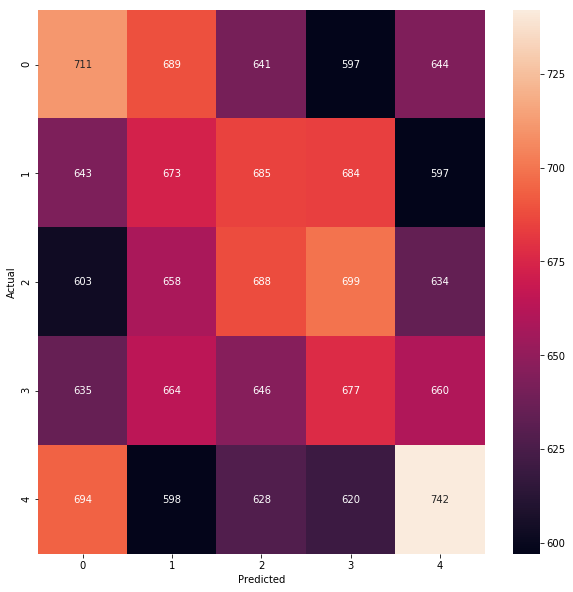

Power_divergenceResult(statistic=array([11.991479  ,  7.3266301 ,  4.50304136, 11.97619774, 17.57583155]), pvalue=array([0.01741474, 0.11960167, 0.34218701, 0.01752915, 0.0014933 ]))
[[0.64308349 0.15691651]
 [0.15667276 0.04332724]]
[[ 0.00308349 -0.00308349]
 [-0.00332724  0.00332724]]
Power_divergenceResult(statistic=6.896042809262645, pvalue=0.0752860993676599)
[[0.64101158 0.15898842]
 [0.15898842 0.04101158]]
[[ 0.00101158 -0.00101158]
 [-0.00101158  0.00101158]]
Power_divergenceResult(statistic=0.6559453077391835, pvalue=0.8835137956764059)
[[0.64156002 0.15843998]
 [0.15807434 0.04192566]]
[[ 0.00156002 -0.00156002]
 [-0.00192566  0.00192566]]
Power_divergenceResult(statistic=2.2135892748324193, pvalue=0.5292766702434089)
[[0.64156002 0.15843998]
 [0.15874467 0.04125533]]
[[ 0.00156002 -0.00156002]
 [-0.00125533  0.00125533]]
Power_divergenceResult(statistic=1.1201249238269348, pvalue=0.7722182023078082)
[[0.64552102 0.15447898]
 [0.15478367 0.04521633]]
[[ 0.00552102 -0.005521

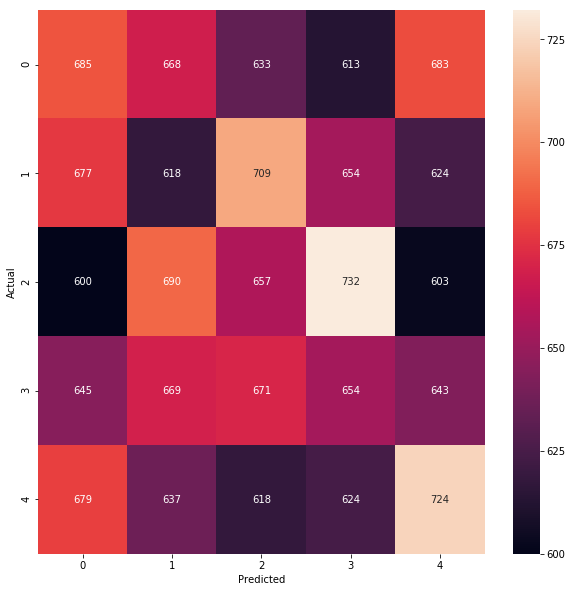

Power_divergenceResult(statistic=array([ 7.70054778,  4.98659354,  7.59610706, 13.20598108, 14.27097955]), pvalue=array([0.10318429, 0.28867585, 0.10754529, 0.01031198, 0.00647858]))
[[0.64149909 0.15850091]
 [0.15825716 0.04174284]]
[[ 0.00149909 -0.00149909]
 [-0.00174284  0.00174284]]
Power_divergenceResult(statistic=1.8457685862279098, pvalue=0.6050261817750471)
[[0.63765996 0.16234004]
 [0.16234004 0.03765996]]
[[-0.00234004  0.00234004]
 [ 0.00234004 -0.00234004]]
Power_divergenceResult(statistic=3.5100548446069473, pvalue=0.31946038076402483)
[[0.63967093 0.16032907]
 [0.15996344 0.04003656]]
[[-3.29067642e-04  3.29067642e-04]
 [-3.65630713e-05  3.65630713e-05]]
Power_divergenceResult(statistic=0.014568098720292504, pvalue=0.9995343861854313)
[[0.64015844 0.15984156]
 [0.16014625 0.03985375]]
[[ 0.00015844 -0.00015844]
 [ 0.00014625 -0.00014625]]
Power_divergenceResult(statistic=0.014187233394271786, pvalue=0.9995524745941438)
[[0.64442413 0.15557587]
 [0.15588056 0.04411944]]
[

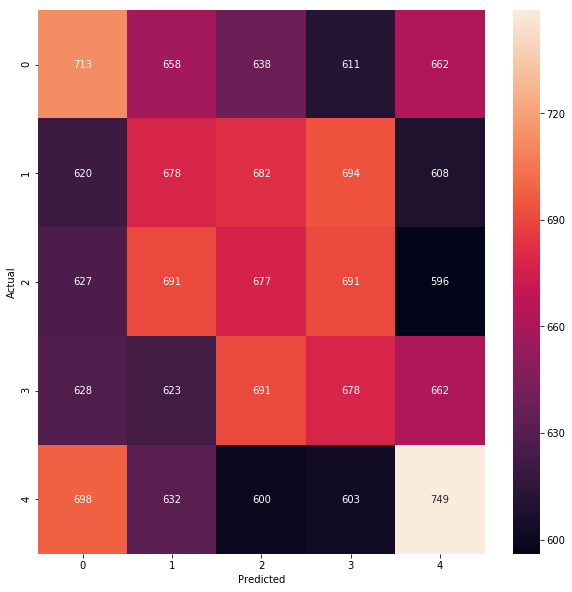

Power_divergenceResult(statistic=array([12.06147292,  5.14503352,  8.80352798, 12.18370461, 22.31187061]), pvalue=array([1.68999435e-02, 2.72737240e-01, 6.62024091e-02, 1.60362140e-02,
       1.73710966e-04]))
[[0.64320536 0.15679464]
 [0.15655088 0.04344912]]
[[ 0.00320536 -0.00320536]
 [-0.00344912  0.00344912]]
Power_divergenceResult(statistic=7.41782830591103, pvalue=0.05970781259653759)
[[0.64131627 0.15868373]
 [0.15868373 0.04131627]]
[[ 0.00131627 -0.00131627]
 [-0.00131627  0.00131627]]
Power_divergenceResult(statistic=1.110603290676417, pvalue=0.7745150434008765)
[[0.6408897  0.1591103 ]
 [0.15874467 0.04125533]]
[[ 0.0008897  -0.0008897 ]
 [-0.00125533  0.00125533]]
Power_divergenceResult(statistic=0.9096016148689823, pvalue=0.8231101218308213)
[[0.64162096 0.15837904]
 [0.15868373 0.04131627]]
[[ 0.00162096 -0.00162096]
 [-0.00131627  0.00131627]]
Power_divergenceResult(statistic=1.2253389701401585, pvalue=0.746933614666738)
[[0.64594759 0.15405241]
 [0.1543571  0.0456429 ]

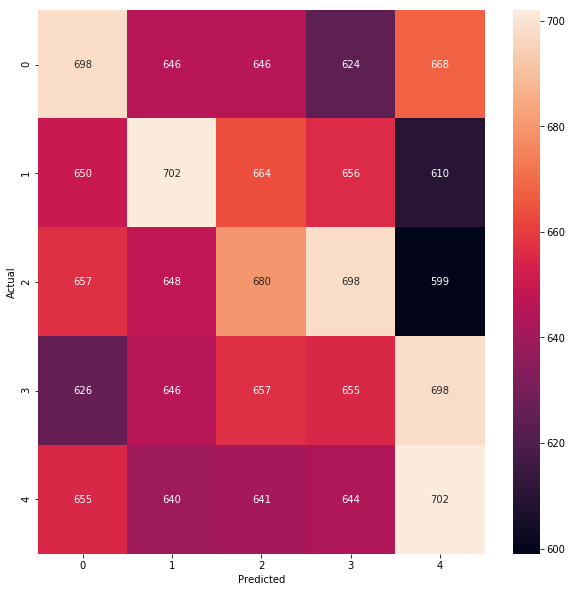

Power_divergenceResult(statistic=array([ 4.10042605,  4.01462523,  1.44951338,  4.47238328, 14.32285627]), pvalue=array([0.39258524, 0.40403016, 0.83554531, 0.34583468, 0.00633282]))
[[0.64229129 0.15770871]
 [0.15746496 0.04253504]]
[[ 0.00229129 -0.00229129]
 [-0.00253504  0.00253504]]
Power_divergenceResult(statistic=3.968616697135893, pvalue=0.2648729616334882)
[[0.64277879 0.15722121]
 [0.15722121 0.04277879]]
[[ 0.00277879 -0.00277879]
 [-0.00277879  0.00277879]]
Power_divergenceResult(statistic=4.9497257769652645, pvalue=0.17551570277952883)
[[0.64107252 0.15892748]
 [0.15856185 0.04143815]]
[[ 0.00107252 -0.00107252]
 [-0.00143815  0.00143815]]
Power_divergenceResult(statistic=1.2081048141377209, pvalue=0.7510611060210435)
[[0.64021938 0.15978062]
 [0.16008531 0.03991469]]
[[ 2.19378428e-04 -2.19378428e-04]
 [ 8.53138330e-05 -8.53138330e-05]]
Power_divergenceResult(statistic=0.009902498476538697, pvalue=0.9997386959336848)
[[0.64308349 0.15691651]
 [0.15722121 0.04277879]]
[[ 0

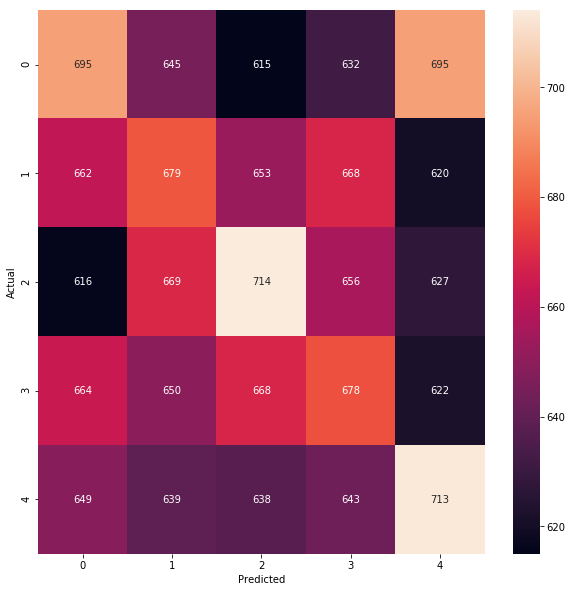

Power_divergenceResult(statistic=array([ 4.96469872,  1.74162096,  8.37773723,  2.09215746, 12.29966433]), pvalue=array([0.29093884, 0.78314397, 0.07868105, 0.71881333, 0.0152566 ]))
[[0.64210847 0.15789153]
 [0.15764778 0.04235222]]
[[ 0.00210847 -0.00210847]
 [-0.00235222  0.00235222]]
Power_divergenceResult(statistic=3.4073164229128583, pvalue=0.33298330462282966)
[[0.64137721 0.15862279]
 [0.15862279 0.04137721]]
[[ 0.00137721 -0.00137721]
 [-0.00137721  0.00137721]]
Power_divergenceResult(statistic=1.2158173369896406, pvalue=0.7492132143681421)
[[0.64314442 0.15685558]
 [0.15648995 0.04351005]]
[[ 0.00314442 -0.00314442]
 [-0.00351005  0.00351005]]
Power_divergenceResult(statistic=7.585694698354661, pvalue=0.055396992896368735)
[[0.64162096 0.15837904]
 [0.15868373 0.04131627]]
[[ 0.00162096 -0.00162096]
 [-0.00131627  0.00131627]]
Power_divergenceResult(statistic=1.2253389701401585, pvalue=0.746933614666738)
[[0.64375381 0.15624619]
 [0.15655088 0.04344912]]
[[ 0.00375381 -0.0037

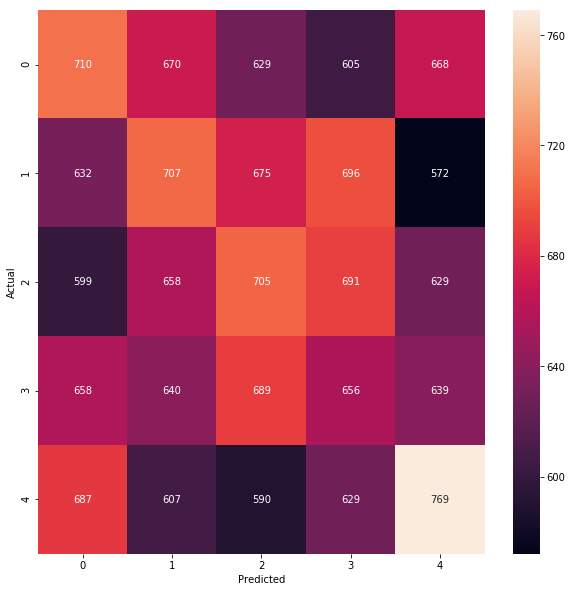

Power_divergenceResult(statistic=array([11.71454656,  8.31383303, 13.56934307,  9.38846506, 32.01891974]), pvalue=array([1.96051420e-02, 8.07354363e-02, 8.80430105e-03, 5.20901866e-02,
       1.89614019e-06]))
[[0.64302255 0.15697745]
 [0.1567337  0.0432663 ]]
[[ 0.00302255 -0.00302255]
 [-0.0032663   0.0032663 ]]
Power_divergenceResult(statistic=6.64229128580134, pvalue=0.08421667044938622)
[[0.64308349 0.15691651]
 [0.15691651 0.04308349]]
[[ 0.00308349 -0.00308349]
 [-0.00308349  0.00308349]]
Power_divergenceResult(statistic=6.094702163315052, pvalue=0.10709257075396617)
[[0.64259598 0.15740402]
 [0.15703839 0.04296161]]
[[ 0.00259598 -0.00259598]
 [-0.00296161  0.00296161]]
Power_divergenceResult(statistic=5.361917276051188, pvalue=0.14713475501922665)
[[0.64028032 0.15971968]
 [0.16002438 0.03997562]]
[[ 2.80316880e-04 -2.80316880e-04]
 [ 2.43753809e-05 -2.43753809e-05]]
Power_divergenceResult(statistic=0.010378580134064595, pvalue=0.9997196672004547)
[[0.64716636 0.15283364]
 [0.

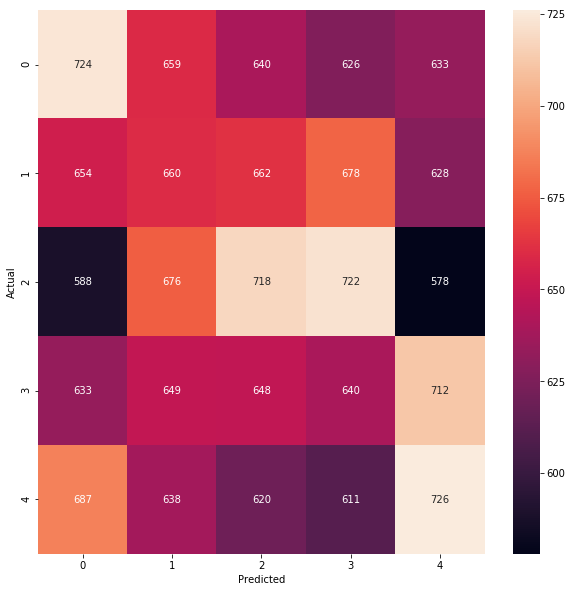

Power_divergenceResult(statistic=array([16.33414486,  1.21450335,  8.33819951, 12.23558132, 23.54470552]), pvalue=array([2.60205321e-03, 8.75705012e-01, 7.99462127e-02, 1.56827596e-02,
       9.85378453e-05]))
[[0.64387569 0.15612431]
 [0.15588056 0.04411944]]
[[ 0.00387569 -0.00387569]
 [-0.00411944  0.00411944]]
Power_divergenceResult(statistic=10.628046922608165, pvalue=0.01391697029022854)
[[0.64021938 0.15978062]
 [0.15978062 0.04021938]]
[[ 0.00021938 -0.00021938]
 [-0.00021938  0.00021938]]
Power_divergenceResult(statistic=0.03085009140767825, pvalue=0.998572133427197)
[[0.64338818 0.15661182]
 [0.15624619 0.04375381]]
[[ 0.00338818 -0.00338818]
 [-0.00375381  0.00375381]]
Power_divergenceResult(statistic=8.697821450335162, pvalue=0.03359037156580528)
[[0.6393053  0.1606947 ]
 [0.16099939 0.03900061]]
[[-0.0006947   0.0006947 ]
 [ 0.00099939 -0.00099939]]
Power_divergenceResult(statistic=0.5740592626447288, pvalue=0.9023443725377921)
[[0.64454601 0.15545399]
 [0.15575868 0.04424

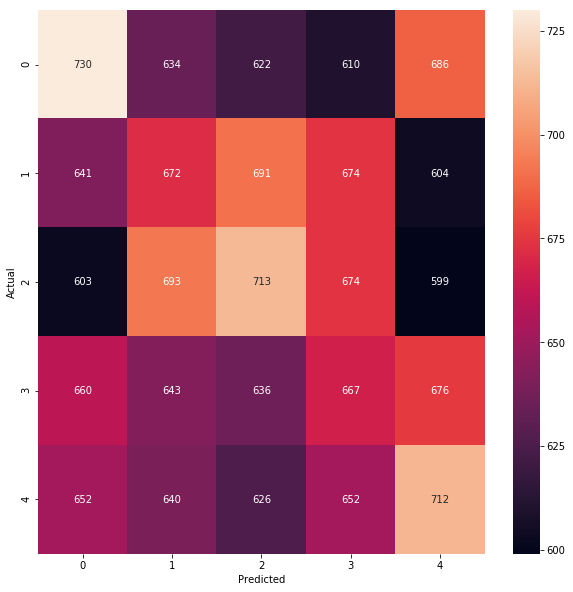

Power_divergenceResult(statistic=array([12.98660986,  3.85923218, 10.51885645,  4.42355813, 15.84864205]), pvalue=array([0.01134141, 0.42539178, 0.03253824, 0.35170798, 0.00322914]))
[[0.64424132 0.15575868]
 [0.15551493 0.04448507]]
[[ 0.00424132 -0.00424132]
 [-0.00448507  0.00448507]]
Power_divergenceResult(statistic=12.621876904326632, pvalue=0.0055299429012639545)
[[0.64095064 0.15904936]
 [0.15904936 0.04095064]]
[[ 0.00095064 -0.00095064]
 [-0.00095064  0.00095064]]
Power_divergenceResult(statistic=0.5792961608775138, pvalue=0.9011552513150485)
[[0.64308349 0.15691651]
 [0.15655088 0.04344912]]
[[ 0.00308349 -0.00308349]
 [-0.00344912  0.00344912]]
Power_divergenceResult(statistic=7.319565051797684, pvalue=0.06238042152518738)
[[0.64095064 0.15904936]
 [0.15935405 0.04064595]]
[[ 0.00095064 -0.00095064]
 [-0.00064595  0.00064595]]
Power_divergenceResult(statistic=0.3298293723339427, pvalue=0.9543241373616503)
[[0.64369287 0.15630713]
 [0.15661182 0.04338818]]
[[ 0.00369287 -0.00

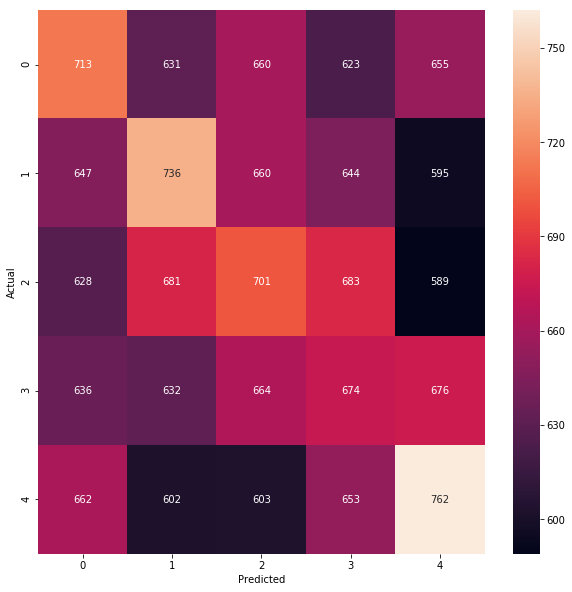

Power_divergenceResult(statistic=array([ 6.91235545, 16.97318708,  7.47749392,  3.49893195, 30.27952395]), pvalue=array([1.40592965e-01, 1.95627339e-03, 1.12705821e-01, 4.78040762e-01,
       4.29320910e-06]))
[[0.64320536 0.15679464]
 [0.15655088 0.04344912]]
[[ 0.00320536 -0.00320536]
 [-0.00344912  0.00344912]]
Power_divergenceResult(statistic=7.41782830591103, pvalue=0.05970781259653759)
[[0.6448507 0.1551493]
 [0.1551493 0.0448507]]
[[ 0.0048507 -0.0048507]
 [-0.0048507  0.0048507]]
Power_divergenceResult(statistic=15.082647775746496, pvalue=0.0017473656067079405)
[[0.64235222 0.15764778]
 [0.15728215 0.04271785]]
[[ 0.00235222 -0.00235222]
 [-0.00271785  0.00271785]]
Power_divergenceResult(statistic=4.497352985984156, pvalue=0.21252651652580698)
[[0.64137721 0.15862279]
 [0.15892748 0.04107252]]
[[ 0.00137721 -0.00137721]
 [-0.00107252  0.00107252]]
Power_divergenceResult(statistic=0.8330476843388177, pvalue=0.8415472179346601)
[[0.64673979 0.15326021]
 [0.1535649  0.0464351 ]]
[

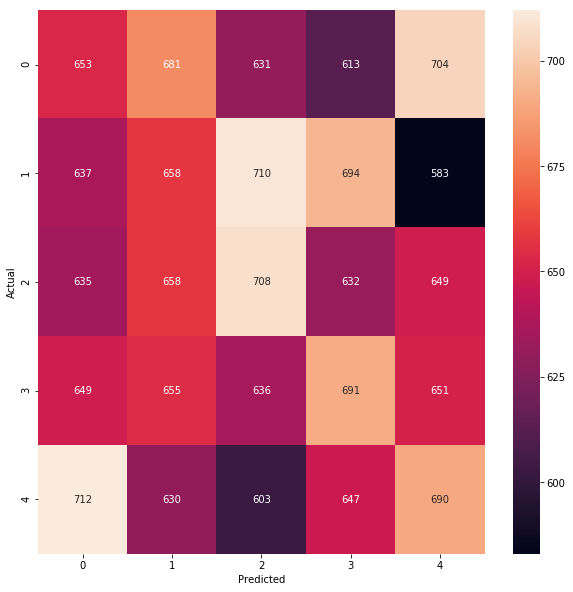

Power_divergenceResult(statistic=array([ 6.06938527,  1.99451554, 14.35705596,  7.893195  , 13.52029295]), pvalue=array([0.19402612, 0.73676769, 0.0062385 , 0.09556988, 0.00899447]))
[[0.63954906 0.16045094]
 [0.16020719 0.03979281]]
[[-0.00045094  0.00045094]
 [ 0.00020719 -0.00020719]]
Power_divergenceResult(statistic=0.048084247410115785, pvalue=0.9972358167095413)
[[0.6400975 0.1599025]
 [0.1599025 0.0400975]]
[[ 9.75015235e-05 -9.75015235e-05]
 [-9.75015235e-05  9.75015235e-05]]
Power_divergenceResult(statistic=0.006093845216331505, pvalue=0.9998737119909951)
[[0.64277879 0.15722121]
 [0.15685558 0.04314442]]
[[ 0.00277879 -0.00277879]
 [-0.00314442  0.00314442]]
Power_divergenceResult(statistic=6.060329067641682, pvalue=0.1087116922847773)
[[0.64241316 0.15758684]
 [0.15789153 0.04210847]]
[[ 0.00241316 -0.00241316]
 [-0.00210847  0.00210847]]
Power_divergenceResult(statistic=3.026355880560634, pvalue=0.3875794413839592)
[[0.64235222 0.15764778]
 [0.15795247 0.04204753]]
[[ 0.002

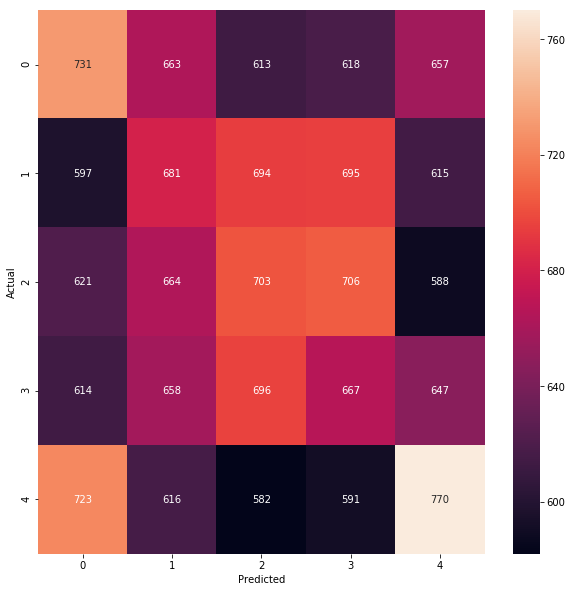

Power_divergenceResult(statistic=array([25.22337188,  3.56672761, 19.10766423, 14.96673787, 29.57155935]), pvalue=array([4.53655634e-05, 4.67805061e-01, 7.48572058e-04, 4.77070453e-03,
       5.98251110e-06]))
[[0.64430225 0.15569775]
 [0.15545399 0.04454601]]
[[ 0.00430225 -0.00430225]
 [-0.00454601  0.00454601]]
Power_divergenceResult(statistic=12.970844759293115, pvalue=0.004700081405009812)
[[0.64149909 0.15850091]
 [0.15850091 0.04149909]]
[[ 0.00149909 -0.00149909]
 [-0.00149909  0.00149909]]
Power_divergenceResult(statistic=1.4405278793418645, pvalue=0.6960628691962826)
[[0.6424741  0.1575259 ]
 [0.15716027 0.04283973]]
[[ 0.0024741  -0.0024741 ]
 [-0.00283973  0.00283973]]
Power_divergenceResult(statistic=4.920113497867154, pvalue=0.17774116361076747)
[[0.64095064 0.15904936]
 [0.15935405 0.04064595]]
[[ 0.00095064 -0.00095064]
 [-0.00064595  0.00064595]]
Power_divergenceResult(statistic=0.3298293723339427, pvalue=0.9543241373616503)
[[0.6472273  0.1527727 ]
 [0.15307739 0.0469

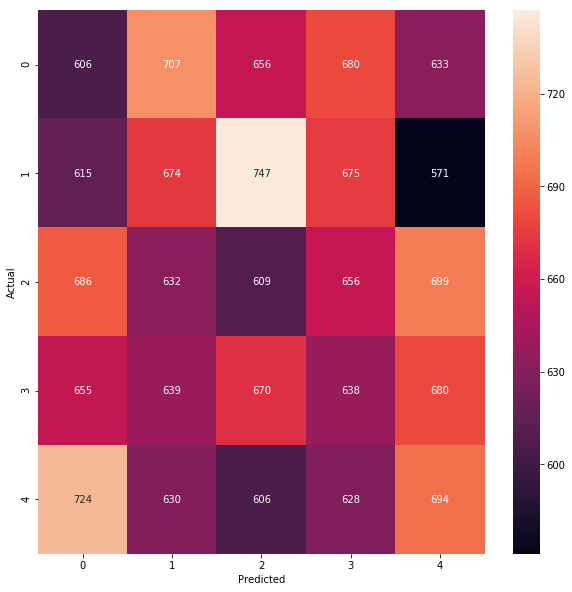

Power_divergenceResult(statistic=array([14.75776019,  6.80255941, 20.03223844,  3.11748551, 17.7314617 ]), pvalue=array([5.23093191e-03, 1.46697246e-01, 4.92133943e-04, 5.38360576e-01,
       1.39248741e-03]))
[[0.63668495 0.16331505]
 [0.1630713  0.0369287 ]]
[[-0.00331505  0.00331505]
 [ 0.0030713  -0.0030713 ]]
Power_divergenceResult(statistic=6.246191346739792, pvalue=0.10022786472040618)
[[0.64107252 0.15892748]
 [0.15892748 0.04107252]]
[[ 0.00107252 -0.00107252]
 [-0.00107252  0.00107252]]
Power_divergenceResult(statistic=0.7373552711761121, pvalue=0.8643843939569522)
[[0.63674589 0.16325411]
 [0.16288848 0.03711152]]
[[-0.00325411  0.00325411]
 [ 0.00288848 -0.00288848]]
Power_divergenceResult(statistic=5.636140310786106, pvalue=0.13071891058446586)
[[0.63918342 0.16081658]
 [0.16112127 0.03887873]]
[[-0.00081658  0.00081658]
 [ 0.00112127 -0.00112127]]
Power_divergenceResult(statistic=0.7302140463132236, pvalue=0.86607532908867)
[[0.64259598 0.15740402]
 [0.15770871 0.04229129

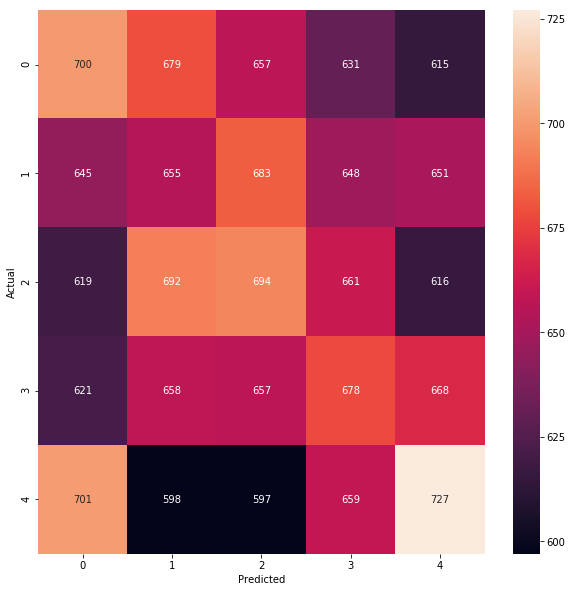

Power_divergenceResult(statistic=array([10.14729154,  7.91163924,  8.58150852,  1.83887702, 12.95270064]), pvalue=array([0.03801834, 0.09486912, 0.07245472, 0.76536242, 0.01150923]))
[[0.64241316 0.15758684]
 [0.15734308 0.04265692]]
[[ 0.00241316 -0.00241316]
 [-0.00265692  0.00265692]]
Power_divergenceResult(statistic=4.366620962827545, pvalue=0.22450042762805333)
[[0.63991469 0.16008531]
 [0.16008531 0.03991469]]
[[-8.5313833e-05  8.5313833e-05]
 [ 8.5313833e-05 -8.5313833e-05]]
Power_divergenceResult(statistic=0.004665600243753809, pvalue=0.9999153606534145)
[[0.64192566 0.15807434]
 [0.15770871 0.04229129]]
[[ 0.00192566 -0.00192566]
 [-0.00229129  0.00229129]]
Power_divergenceResult(statistic=3.167656916514321, pvalue=0.3664910896571056)
[[0.64162096 0.15837904]
 [0.15868373 0.04131627]]
[[ 0.00162096 -0.00162096]
 [-0.00131627  0.00131627]]
Power_divergenceResult(statistic=1.2253389701401585, pvalue=0.746933614666738)
[[0.64460695 0.15539305]
 [0.15569775 0.04430225]]
[[ 0.00460

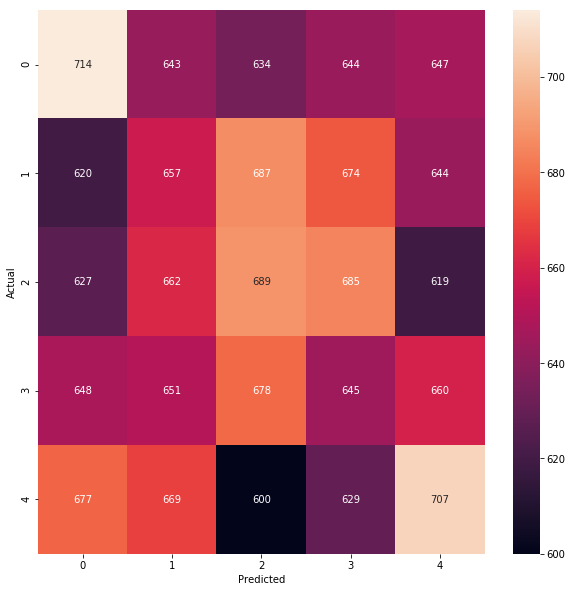

Power_divergenceResult(statistic=array([9.12781497, 0.60816575, 9.33880779, 3.29142508, 6.4223375 ]), pvalue=array([0.05798292, 0.96215198, 0.05316687, 0.51029202, 0.16975   ]))
[[0.6432663  0.1567337 ]
 [0.15648995 0.04351005]]
[[ 0.0032663  -0.0032663 ]
 [-0.00351005  0.00351005]]
Power_divergenceResult(statistic=7.685862279098111, pvalue=0.05297033585270303)
[[0.64003656 0.15996344]
 [0.15996344 0.04003656]]
[[ 3.65630713e-05 -3.65630713e-05]
 [-3.65630713e-05  3.65630713e-05]]
Power_divergenceResult(statistic=0.000856946983546618, pvalue=0.9999933298117516)
[[0.64162096 0.15837904]
 [0.15801341 0.04198659]]
[[ 0.00162096 -0.00162096]
 [-0.00198659  0.00198659]]
Power_divergenceResult(statistic=2.360698507007922, pvalue=0.5009925089079257)
[[0.63960999 0.16039001]
 [0.1606947  0.0393053 ]]
[[-0.00039001  0.00039001]
 [ 0.0006947  -0.0006947 ]]
Power_divergenceResult(statistic=0.26698659354052406, pvalue=0.9661129222726299)
[[0.64338818 0.15661182]
 [0.15691651 0.04308349]]
[[ 0.0033

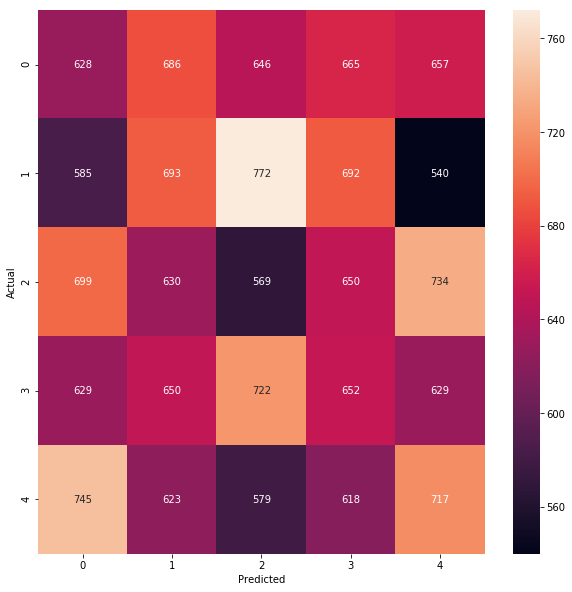

Power_divergenceResult(statistic=array([24.82775411,  6.19926874, 47.74513382,  4.38083613, 36.60238023]), pvalue=array([5.44848824e-05, 1.84752797e-01, 1.06658760e-09, 3.56911973e-01,
       2.17509490e-07]))
[[0.63802559 0.16197441]
 [0.16173065 0.03826935]]
[[-0.00197441  0.00197441]
 [ 0.00173065 -0.00173065]]
Power_divergenceResult(statistic=2.0357251675807433, pvalue=0.5650250200484885)
[[0.64223035 0.15776965]
 [0.15776965 0.04223035]]
[[ 0.00223035 -0.00223035]
 [-0.00223035  0.00223035]]
Power_divergenceResult(statistic=3.1886997257769654, pvalue=0.3634363738972374)
[[0.63430835 0.16569165]
 [0.16532602 0.03467398]]
[[-0.00569165  0.00569165]
 [ 0.00532602 -0.00532602]]
Power_divergenceResult(statistic=18.699820993296772, pvalue=0.0003153846598833548)
[[0.64003656 0.15996344]
 [0.16026813 0.03973187]]
[[ 3.65630713e-05 -3.65630713e-05]
 [ 2.68129190e-04 -2.68129190e-04]]
Power_divergenceResult(statistic=0.03703915295551493, pvalue=0.9981250498908962)
[[0.64399756 0.15600244]
 

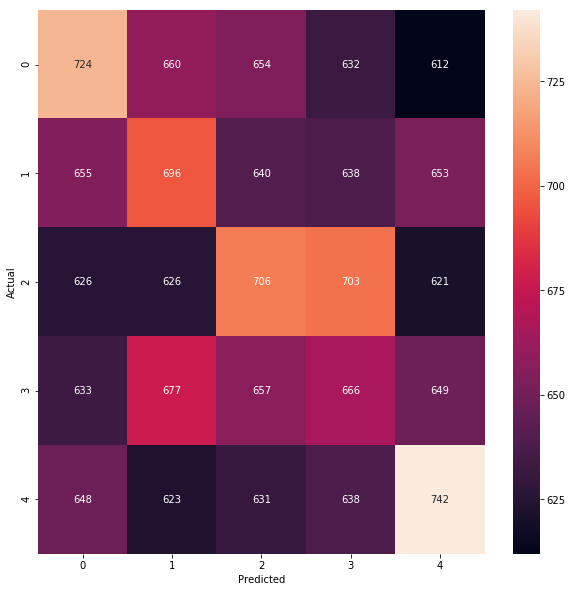

Power_divergenceResult(statistic=array([ 9.29823494,  6.16270567,  5.12956204,  5.38785475, 16.19346964]), pvalue=array([0.0540623 , 0.18732235, 0.27426009, 0.24976441, 0.00277025]))
[[0.64387569 0.15612431]
 [0.15588056 0.04411944]]
[[ 0.00387569 -0.00387569]
 [-0.00411944  0.00411944]]
Power_divergenceResult(statistic=10.628046922608165, pvalue=0.01391697029022854)
[[0.64241316 0.15758684]
 [0.15758684 0.04241316]]
[[ 0.00241316 -0.00241316]
 [-0.00241316  0.00241316]]
Power_divergenceResult(statistic=3.7328610603290677, pvalue=0.2917926922496634)
[[0.64265692 0.15734308]
 [0.15697745 0.04302255]]
[[ 0.00265692 -0.00265692]
 [-0.00302255  0.00302255]]
Power_divergenceResult(statistic=5.589960390006094, pvalue=0.1333559111640529)
[[0.6408897  0.1591103 ]
 [0.15941499 0.04058501]]
[[ 0.0008897  -0.0008897 ]
 [-0.00058501  0.00058501]]
Power_divergenceResult(statistic=0.2769843083485679, pvalue=0.9642973490439882)
[[0.64552102 0.15447898]
 [0.15478367 0.04521633]]
[[ 0.00552102 -0.00552

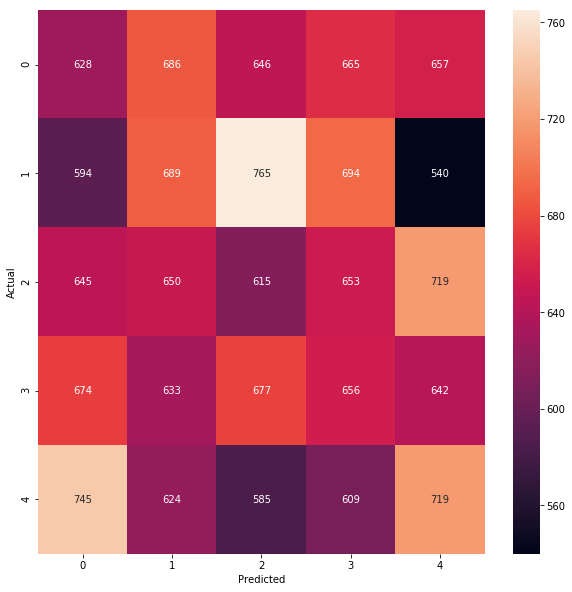

Power_divergenceResult(statistic=array([19.76080341,  5.44972578, 29.09245742,  5.70826976, 32.94049435]), pvalue=array([5.56725342e-04, 2.44184096e-01, 7.48648901e-06, 2.22019889e-01,
       1.22846160e-06]))
[[0.63802559 0.16197441]
 [0.16173065 0.03826935]]
[[-0.00197441  0.00197441]
 [ 0.00173065 -0.00173065]]
Power_divergenceResult(statistic=2.0357251675807433, pvalue=0.5650250200484885)
[[0.64198659 0.15801341]
 [0.15801341 0.04198659]]
[[ 0.00198659 -0.00198659]
 [-0.00198659  0.00198659]]
Power_divergenceResult(statistic=2.5298027117611213, pvalue=0.46992913503939604)
[[0.63711152 0.16288848]
 [0.16252285 0.03747715]]
[[-0.00288848  0.00288848]
 [ 0.00252285 -0.00252285]]
Power_divergenceResult(statistic=4.333580895795247, pvalue=0.22762356181718046)
[[0.64028032 0.15971968]
 [0.16002438 0.03997562]]
[[ 2.80316880e-04 -2.80316880e-04]
 [ 2.43753809e-05 -2.43753809e-05]]
Power_divergenceResult(statistic=0.010378580134064595, pvalue=0.9997196672004547)
[[0.64411944 0.15588056]
 [

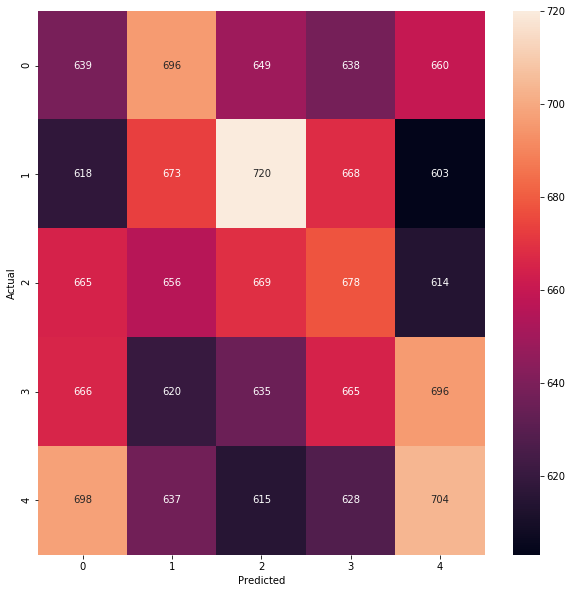

Power_divergenceResult(statistic=array([ 5.5855143 ,  5.40097502,  9.7676399 ,  2.76960635, 12.95575221]), pvalue=array([0.23231434, 0.24857195, 0.04452904, 0.5970905 , 0.01149403]))
[[0.63869592 0.16130408]
 [0.16106033 0.03893967]]
[[-0.00130408  0.00130408]
 [ 0.00106033 -0.00106033]]
Power_divergenceResult(statistic=0.7945802864107252, pvalue=0.8507629135354867)
[[0.64101158 0.15898842]
 [0.15898842 0.04101158]]
[[ 0.00101158 -0.00101158]
 [-0.00101158  0.00101158]]
Power_divergenceResult(statistic=0.6559453077391835, pvalue=0.8835137956764059)
[[0.64040219 0.15959781]
 [0.15923218 0.04076782]]
[[ 0.00040219 -0.00040219]
 [-0.00076782  0.00076782]]
Power_divergenceResult(statistic=0.32306901279707495, pvalue=0.9556330091812937)
[[0.64082876 0.15917124]
 [0.15947593 0.04052407]]
[[ 0.00082876 -0.00082876]
 [-0.00052407  0.00052407]]
Power_divergenceResult(statistic=0.22890006093845217, pvalue=0.9727942721616479)
[[0.64320536 0.15679464]
 [0.15709933 0.04290067]]
[[ 0.00320536 -0.003

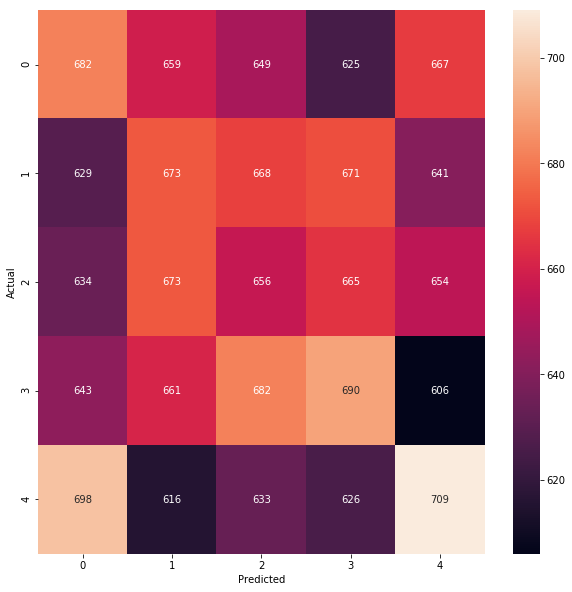

Power_divergenceResult(statistic=array([5.80462568, 3.36867764, 2.10644769, 5.06743973, 8.63167531]), pvalue=array([0.21422178, 0.49812493, 0.71618793, 0.28044749, 0.07099491]))
[[0.64131627 0.15868373]
 [0.15843998 0.04156002]]
[[ 0.00131627 -0.00131627]
 [-0.00156002  0.00156002]]
Power_divergenceResult(statistic=1.4701401584399756, pvalue=0.6891789127207171)
[[0.64101158 0.15898842]
 [0.15898842 0.04101158]]
[[ 0.00101158 -0.00101158]
 [-0.00101158  0.00101158]]
Power_divergenceResult(statistic=0.6559453077391835, pvalue=0.8835137956764059)
[[0.63960999 0.16039001]
 [0.16002438 0.03997562]]
[[-3.90006094e-04  3.90006094e-04]
 [ 2.43753809e-05 -2.43753809e-05]]
Power_divergenceResult(statistic=0.019804996953077393, pvalue=0.9992631109943299)
[[0.64235222 0.15764778]
 [0.15795247 0.04204753]]
[[ 0.00235222 -0.00235222]
 [-0.00204753  0.00204753]]
Power_divergenceResult(statistic=2.8592512187690433, pvalue=0.41383876046988954)
[[0.64351005 0.15648995]
 [0.15679464 0.04320536]]
[[ 0.003

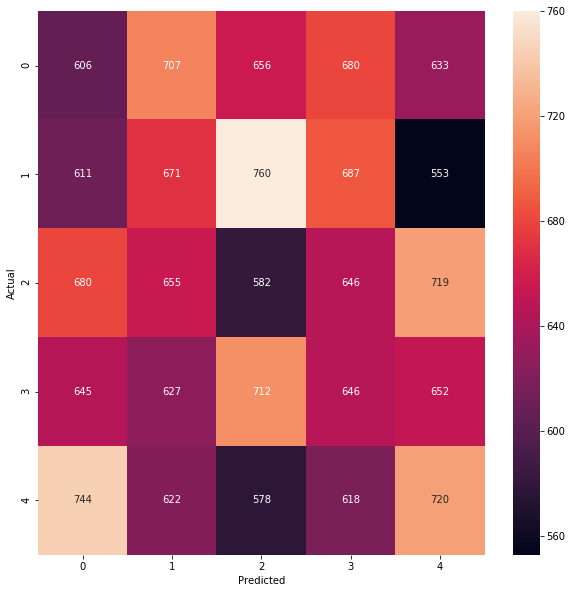

Power_divergenceResult(statistic=array([19.71819842,  7.34795856, 38.77615572,  4.85077815, 29.32133049]), pvalue=array([5.67598734e-04, 1.18603595e-01, 7.74891781e-08, 3.02954087e-01,
       6.72611348e-06]))
[[0.63668495 0.16331505]
 [0.1630713  0.0369287 ]]
[[-0.00331505  0.00331505]
 [ 0.0030713  -0.0030713 ]]
Power_divergenceResult(statistic=6.246191346739792, pvalue=0.10022786472040618)
[[0.6408897 0.1591103]
 [0.1591103 0.0408897]]
[[ 0.0008897 -0.0008897]
 [-0.0008897  0.0008897]]
Power_divergenceResult(statistic=0.507407830591103, pvalue=0.9172609554429294)
[[0.63510055 0.16489945]
 [0.16453382 0.03546618]]
[[-0.00489945  0.00489945]
 [ 0.00453382 -0.00453382]]
Power_divergenceResult(statistic=13.618601462522854, pvalue=0.0034730667166958653)
[[0.63967093 0.16032907]
 [0.16063376 0.03936624]]
[[-0.00032907  0.00032907]
 [ 0.00063376 -0.00063376]]
Power_divergenceResult(statistic=0.2198545094454601, pvalue=0.9743221948147153)
[[0.64418038 0.15581962]
 [0.15612431 0.04387569]]
[

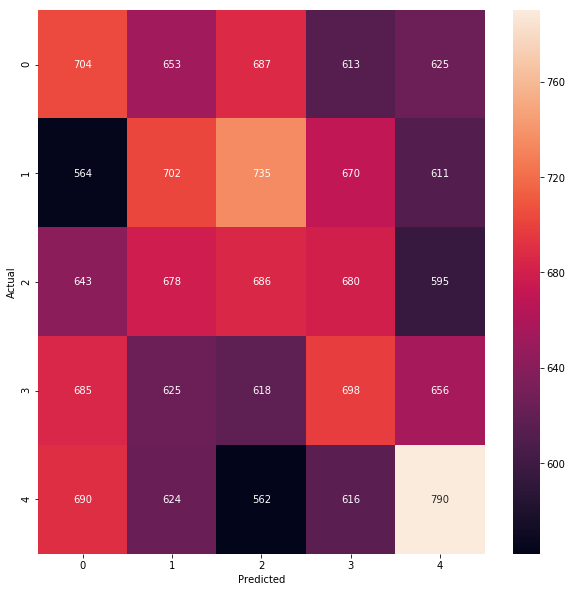

Power_divergenceResult(statistic=array([19.669507  ,  6.99756246, 27.9336983 ,  9.12908148, 37.62770827]), pvalue=array([5.80283016e-04, 1.36017094e-01, 1.28648541e-05, 5.79528063e-02,
       1.33726023e-07]))
[[0.64265692 0.15734308]
 [0.15709933 0.04290067]]
[[ 0.00265692 -0.00265692]
 [-0.00290067  0.00290067]]
Power_divergenceResult(statistic=5.219759293113955, pvalue=0.15639465340197942)
[[0.64277879 0.15722121]
 [0.15722121 0.04277879]]
[[ 0.00277879 -0.00277879]
 [-0.00277879  0.00277879]]
Power_divergenceResult(statistic=4.9497257769652645, pvalue=0.17551570277952883)
[[0.64143815 0.15856185]
 [0.15819622 0.04180378]]
[[ 0.00143815 -0.00143815]
 [-0.00180378  0.00180378]]
Power_divergenceResult(statistic=1.9336532602071907, pvalue=0.5862907564669411)
[[0.64283973 0.15716027]
 [0.15746496 0.04253504]]
[[ 0.00283973 -0.00283973]
 [-0.00253504  0.00253504]]
Power_divergenceResult(statistic=4.329391377209019, pvalue=0.22802242360023672)
[[0.64844607 0.15155393]
 [0.15185862 0.04814

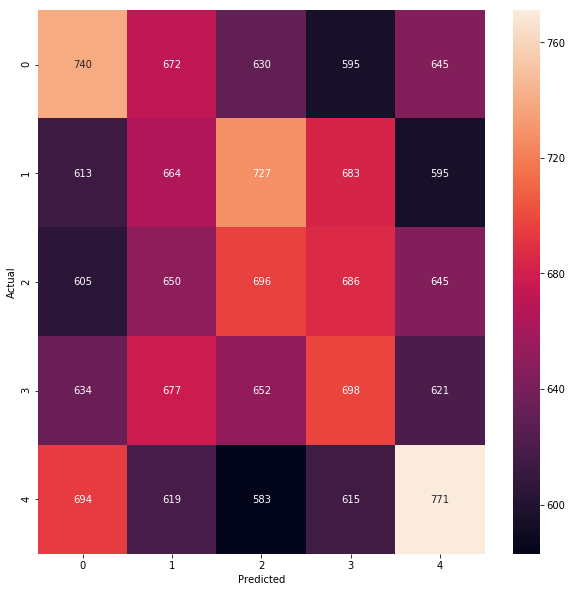

Power_divergenceResult(statistic=array([20.43031041,  3.29859842, 19.23540146, 13.41653952, 28.09154715]), pvalue=array([4.10600762e-04, 5.09154357e-01, 7.06506439e-04, 9.41005941e-03,
       1.19512289e-05]))
[[0.6448507  0.1551493 ]
 [0.15490555 0.04509445]]
[[ 0.0048507  -0.0048507 ]
 [-0.00509445  0.00509445]]
Power_divergenceResult(statistic=16.325792199878123, pvalue=0.0009722504589152404)
[[0.64046313 0.15953687]
 [0.15953687 0.04046313]]
[[ 0.00046313 -0.00046313]
 [-0.00046313  0.00046313]]
Power_divergenceResult(statistic=0.13749238269347958, pvalue=0.9869865148200957)
[[0.64204753 0.15795247]
 [0.15758684 0.04241316]]
[[ 0.00204753 -0.00204753]
 [-0.00241316  0.00241316]]
Power_divergenceResult(statistic=3.523765996343693, pvalue=0.31769280694716634)
[[0.64283973 0.15716027]
 [0.15746496 0.04253504]]
[[ 0.00283973 -0.00283973]
 [-0.00253504  0.00253504]]
Power_divergenceResult(statistic=4.329391377209019, pvalue=0.22802242360023672)
[[0.64728824 0.15271176]
 [0.15301645 0.04

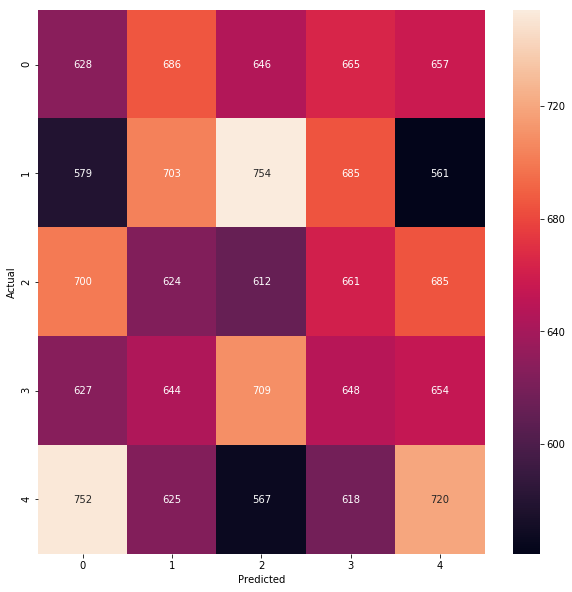

Power_divergenceResult(statistic=array([28.45222155,  7.97867154, 33.99817518,  3.74305767, 21.30790357]), pvalue=array([1.00987490e-05, 9.23626150e-02, 7.45831209e-07, 4.41894438e-01,
       2.75119103e-04]))
[[0.63802559 0.16197441]
 [0.16173065 0.03826935]]
[[-0.00197441  0.00197441]
 [ 0.00173065 -0.00173065]]
Power_divergenceResult(statistic=2.0357251675807433, pvalue=0.5650250200484885)
[[0.64283973 0.15716027]
 [0.15716027 0.04283973]]
[[ 0.00283973 -0.00283973]
 [-0.00283973  0.00283973]]
Power_divergenceResult(statistic=5.169199421084705, pvalue=0.15981859908802898)
[[0.6369287  0.1630713 ]
 [0.16270567 0.03729433]]
[[-0.0030713   0.0030713 ]
 [ 0.00270567 -0.00270567]]
Power_divergenceResult(statistic=4.963436928702011, pvalue=0.17449413395827934)
[[0.63979281 0.16020719]
 [0.16051188 0.03948812]]
[[-0.00020719  0.00020719]
 [ 0.00051188 -0.00051188]]
Power_divergenceResult(statistic=0.13987279098110908, pvalue=0.9866565586390139)
[[0.64418038 0.15581962]
 [0.15612431 0.04387

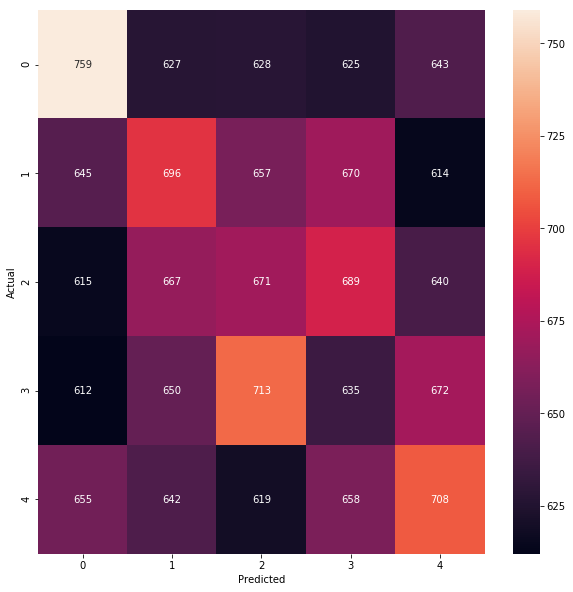

Power_divergenceResult(statistic=array([21.82105904,  4.25533211,  8.53892944,  4.10314312,  7.85352457]), pvalue=array([2.17544599e-04, 3.72551871e-01, 7.37159612e-02, 3.92226878e-01,
       9.70935582e-02]))
[[0.64600853 0.15399147]
 [0.15374771 0.04625229]]
[[ 0.00600853 -0.00600853]
 [-0.00625229  0.00625229]]
Power_divergenceResult(statistic=24.67483622790981, pvalue=1.805643699563397e-05)
[[0.64241316 0.15758684]
 [0.15758684 0.04241316]]
[[ 0.00241316 -0.00241316]
 [-0.00241316  0.00241316]]
Power_divergenceResult(statistic=3.7328610603290677, pvalue=0.2917926922496634)
[[0.64052407 0.15947593]
 [0.1591103  0.0408897 ]]
[[ 0.00052407 -0.00052407]
 [-0.0008897   0.0008897 ]]
Power_divergenceResult(statistic=0.4411372638634979, pvalue=0.9316193332898527)
[[0.63900061 0.16099939]
 [0.16130408 0.03869592]]
[[-0.00099939  0.00099939]
 [ 0.00130408 -0.00130408]]
Power_divergenceResult(statistic=1.0001523461304083, pvalue=0.8012150935977196)
[[0.64344912 0.15655088]
 [0.15685558 0.0431

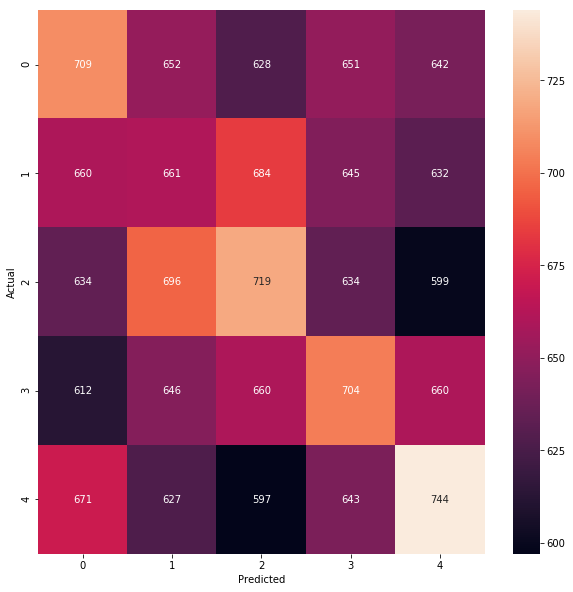

Power_divergenceResult(statistic=array([ 8.31223372,  3.93235832, 13.71836983,  4.73176686, 17.97253586]), pvalue=array([0.08078749, 0.41523755, 0.00825033, 0.31594316, 0.00124944]))
[[0.64296161 0.15703839]
 [0.15679464 0.04320536]]
[[ 0.00296161 -0.00296161]
 [-0.00320536  0.00320536]]
Power_divergenceResult(statistic=6.393300578915295, pvalue=0.09396679024014892)
[[0.64028032 0.15971968]
 [0.15971968 0.04028032]]
[[ 0.00028032 -0.00028032]
 [-0.00028032  0.00028032]]
Power_divergenceResult(statistic=0.0503694393662401, pvalue=0.9970384683198226)
[[0.64344912 0.15655088]
 [0.15618525 0.04381475]]
[[ 0.00344912 -0.00344912]
 [-0.00381475  0.00381475]]
Power_divergenceResult(statistic=8.987755179768435, pvalue=0.029454131870290088)
[[0.64320536 0.15679464]
 [0.15709933 0.04290067]]
[[ 0.00320536 -0.00320536]
 [-0.00290067  0.00290067]]
Power_divergenceResult(statistic=5.631950792199878, pvalue=0.13095608452326069)
[[0.6456429  0.1543571 ]
 [0.15466179 0.04533821]]
[[ 0.0056429  -0.0056

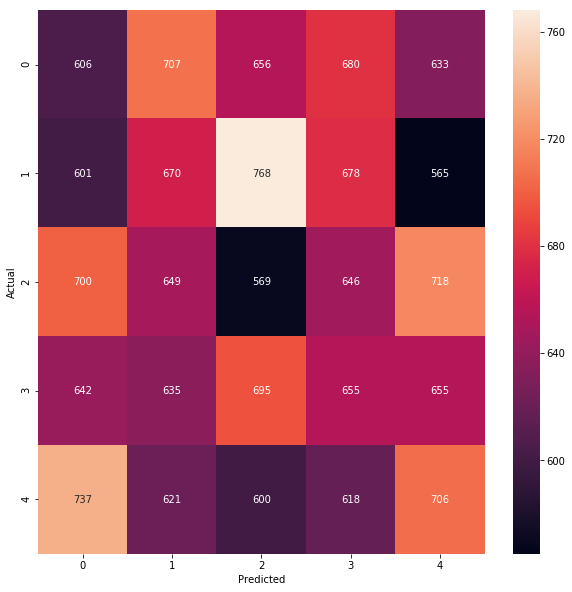

Power_divergenceResult(statistic=array([21.62325015,  6.87263863, 37.64781022,  3.97192554, 23.12053708]), pvalue=array([2.38166427e-04, 1.42773722e-01, 1.32455835e-07, 4.09818648e-01,
       1.19794834e-04]))
[[0.63668495 0.16331505]
 [0.1630713  0.0369287 ]]
[[-0.00331505  0.00331505]
 [ 0.0030713  -0.0030713 ]]
Power_divergenceResult(statistic=6.246191346739792, pvalue=0.10022786472040618)
[[0.64082876 0.15917124]
 [0.15917124 0.04082876]]
[[ 0.00082876 -0.00082876]
 [-0.00082876  0.00082876]]
Power_divergenceResult(statistic=0.44028031687995123, pvalue=0.9318014044460035)
[[0.63430835 0.16569165]
 [0.16532602 0.03467398]]
[[-0.00569165  0.00569165]
 [ 0.00532602 -0.00532602]]
Power_divergenceResult(statistic=18.699820993296772, pvalue=0.0003153846598833548)
[[0.64021938 0.15978062]
 [0.16008531 0.03991469]]
[[ 2.19378428e-04 -2.19378428e-04]
 [ 8.53138330e-05 -8.53138330e-05]]
Power_divergenceResult(statistic=0.009902498476538697, pvalue=0.9997386959336848)
[[0.64332724 0.15667276]

In [19]:
MODELPREFIX = "NNclass"

n_hiddens = [1, 2, 3]
layer_sizes = [8, 16, 32]
reg_penalties = [0.0, 0.01, 1]
hyperparameter_combos = list(product(n_hiddens, layer_sizes, reg_penalties))

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
# should really just use a list and convert to dataframe
experiments = {}
sharpes = {}
quantile_scores = {}

for counter, param_list in enumerate(hyperparameter_combos):
    n_hidden_layers, layer_size, reg_penalty = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (n_hidden_layers, layer_size, reg_penalty)
    print("%s n_hidden_layers = %d, hidden_layer_size = %d, reg_penalty = %.6f" % 
          (time.strftime("%H:%M:%S"), n_hidden_layers, layer_size, reg_penalty))
    
    experiment_model = BacktestModel(X, Y_class, 
                                     create_keras_model(n_hidden_layers,layer_size,reg_penalty), 
                                     coef_dict_param="all", 
                                     startindex=FIRST_TRAIN_MONTHS)
    experiment_model.walkforward_xval(n_splits=5)
    score = experiment_model.evaluate_predictions()
    experiments[key] = score
    quantile_score = experiment_model.evaluate_quantiles(chart=True, verbose=True, Y=Y)
    quantile_scores[key] = quantile_score

    experiment_model.gen_returns(calc_returns, verbose=False)
    retframe = experiment_model.report_returns(start_date=start_date_str, freq='M')
    sharpe = retframe.loc['yearly_sharpe']
    sharpes[key] = sharpe.values[0]
    
    print("%s Quantile score: %f" % (str(key), quantile_score))
    print("%s Sharpe: %f" % (str(key), sharpe))



In [20]:
# list and chart experiments
flatlist = [list(l[0]) + [l[1]] for l in experiments.items()]
 
lossframe = pd.DataFrame(flatlist, columns=["n_hidden_layers", "layer_size", "reg_penalty", "MSE"])
# one row didn't converge properly - messes up plotly scales
#for i in list(lossframe.loc[lossframe['loss']> 1000].index):
#    lossframe.at[i, 'loss'] = 100
lossframe.sort_values(['MSE'])

,n_hidden_layers,layer_size,reg_penalty,MSE
15,3,8,1.00,0.999062
25,2,8,1.00,0.999437
5,3,16,1.00,0.999560
9,2,16,1.00,0.999576
18,2,32,1.00,0.999659
7,3,32,1.00,0.999772
11,3,8,0.00,1.001408
19,1,8,1.00,1.003651
26,1,16,1.00,1.005644
12,3,8,0.01,1.006596


In [21]:
# list sharpes
flatlist = [list(l[0]) + [l[1]] for l in sharpes.items()]
 
sharpeframe = pd.DataFrame(flatlist, columns=["n_hidden_layers", "layer_size", "reg_penalty", "sharpe"])
# one row didn't converge properly - messes up plotly scales
#for i in list(lossframe.loc[lossframe['loss']> 1000].index):
#    lossframe.at[i, 'loss'] = 100
#list(l) +
sharpeframe.sort_values(['sharpe'])

,n_hidden_layers,layer_size,reg_penalty,sharpe
25,2,8,1.00,-0.138173
18,2,32,1.00,-0.131132
7,3,32,1.00,-0.127520
9,2,16,1.00,-0.127222
5,3,16,1.00,-0.126022
15,3,8,1.00,-0.113753
2,2,8,0.00,-0.062298
11,3,8,0.00,-0.000333
21,1,16,0.01,0.069590
12,3,8,0.01,0.096124


In [22]:
# list quantile scores
flatlist = [list(l[0]) + [l[1]] for l in quantile_scores.items()]
 
qframe = pd.DataFrame(flatlist, columns=["n_hidden_layers", "layer_size", "reg_penalty", "qscore"])
# one row didn't converge properly - messes up plotly scales
#for i in list(lossframe.loc[lossframe['loss']> 1000].index):
#    lossframe.at[i, 'loss'] = 100
#list(l) +
qframe.sort_values(['qscore'])

,n_hidden_layers,layer_size,reg_penalty,qscore
25,2,8,1.00,-0.000375
7,3,32,1.00,-0.000009
15,3,8,1.00,0.000417
2,2,8,0.00,0.000935
11,3,8,0.00,0.000935
9,2,16,1.00,0.000996
18,2,32,1.00,0.001057
5,3,16,1.00,0.001088
12,3,8,0.01,0.002398
24,1,16,0.00,0.002672


In [23]:
sharpes_array = sharpeframe.values[:,3]
print(sharpes_array.shape)
mses_array = lossframe.values[:,3]
print(mses_array.shape)
qscore_array = qframe.values[:,3]
print(qscore_array.shape)

(27,)
(27,)
(27,)


In [24]:
def myscatter(arg1, arg2, names=None):
    
    plotdata = []
    
    plotdata.append(Scatter(
        x = arg1,
        y = arg2,
        mode = 'markers'
    ))
    
    layout = Layout(
        autosize=False,
        width=600,
        height=480,
        yaxis=dict(
            type='log',
            autorange=True
        )
    )
    
    fig = Figure(data=plotdata, layout=layout)
    
    return iplot(fig)
    
myscatter(sharpes_array, mses_array)
# MSEs worse than linear regression
# no very good Sharpes
# weak correlation between MSEs, Sharpes, which is perplexing

In [25]:
myscatter(sharpes_array, qscore_array)


In [26]:
# we can pick lowest loss , but first we look at patterns by hyperparameter
pd.DataFrame(qframe.groupby(['n_hidden_layers'])['qscore'].mean())


,qscore
n_hidden_layers,
1,0.003952
2,0.002716
3,0.002824


In [27]:
pd.DataFrame(qframe.groupby(['layer_size'])['qscore'].mean())


,qscore
layer_size,
8,0.002428
16,0.003461
32,0.003603


In [28]:
pd.DataFrame(qframe.groupby(['reg_penalty'])['qscore'].mean())


,qscore
reg_penalty,
0.00,0.003485
0.01,0.004033
1.00,0.001975


In [29]:
def plot_matrix(lossframe, x_labels, y_labels, x_suffix="", y_suffix=""):

    pivot = lossframe.pivot_table(index=[y_labels], columns=[x_labels], values=['qscore'])
#    print(pivot)
    # specify labels as strings, to force plotly to use a discrete axis
#    print(pivot.columns.levels[1]).values
#    print(lossframe[x_labels].dtype)
    
    if lossframe[x_labels].dtype == np.float64 or lossframe[x_labels].dtype == np.float32:
        xaxis = ["%f %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    else:
        xaxis = ["%d %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    if lossframe[y_labels].dtype == np.float64 or lossframe[y_labels].dtype == np.float32:
        yaxis = ["%f %s" % (i, y_suffix) for i in pivot.index.values]
    else:
        yaxis = ["%d %s" % (i, y_suffix) for i in pivot.index.values]
        
#    print(xaxis, yaxis)
    """plot a heat map of a matrix"""
    chart_width=640
    chart_height=480
    
    layout = Layout(
        title="%s v. %s" % (x_labels, y_labels),
        height=chart_height,
        width=chart_width,     
        margin=dict(
            l=150,
            r=30,
            b=120,
            t=100,
        ),
        xaxis=dict(
            title=x_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
        yaxis=dict(
            title=y_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
    )
    
    data = [Heatmap(z=pivot.values,
                    x=xaxis,
                    y=yaxis,
                    colorscale=[[0, 'rgb(0,0,255)', [1, 'rgb(255,0,0)']]],
                   )
           ]

    fig = Figure(data=data, layout=layout)
    return iplot(fig, link_text="")

plot_matrix(qframe, "n_hidden_layers", "layer_size", x_suffix=" layers", y_suffix=" units")




In [30]:
plot_matrix(qframe, "n_hidden_layers", "reg_penalty", x_suffix=" layers", y_suffix=" p")


In [31]:
plot_matrix(qframe, "reg_penalty", "layer_size", x_suffix=" p", y_suffix="units")


In [ ]:
backtestmodel = BacktestModel(X, Y_class, 
                              model=create_keras_model(3,4,0.01), 
                              coef_dict_param=coef_dict_all, 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean')
backtestmodel.gen_predictions(verbose=False)
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True, Y=Y)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')


1/1 [==============================] - 0s 20ms/step
.